# NLP Launch: Natural Language Predictor Project

<div class="alert alert-success">  
    
## Goals: 
    
* The project goal is to predict which programming language is used based solely on GitHub README's. 
* This analysis aims to address the listed questions and uncover any additional important findings related goal.
</div>

# `Imports`

In [1]:
#.py modules
import acquire as ac
import prepare as pp
import explore as ex
import evaluate as ev

#standard
import pandas as pd
import numpy as np
import re

#scraping
import requests
from requests import get
from bs4 import BeautifulSoup

#file
import os
import json

#vizz
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#split and model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

json file found and loaded
imports loaded successfully, awaiting commands...


# `Acquire`

### Acquire
* Data acquired from GitHub using Selenium
    * env.py credentials used to access GitHub
* 740 rows × 1 column before cleaning
* 740 rows × 3 columns after cleaning and acquiring READMEs


### Data Dictionary

| Feature | Definition|
|:--------|:-----------|
|repo| The 'author name/repo name' of the repo|
|language| The repo language used|
|readme| The cleaned contents of unqiue READMEs|

In [2]:
#get repo authors and names
click_data = ac.button_click()

json file found and loaded


In [3]:
#quick peek
click_data

,string
0,sindresorhus / awesome
1,vinta / awesome-python
2,awesome-selfhosted / awesome-selfhosted
3,avelino / awesome-go
4,trimstray / the-book-of-secret-knowledge
...,...
735,hetznercloud / awesome-hcloud
736,chinaBerg / awesome-canvas
737,RichardLitt / awesome-conferences
738,styfle / awesome-desktop-js


In [4]:
#get readme contents and add to click_data
scraped = ac.get_scraped_data()

json file found and loaded


In [5]:
#quick peek
scraped

,repo,language,readme_contents
0,sindresorhus/awesome,None,"<div align=""center"">\n\t<a href=""https://vshym..."
1,vinta/awesome-python,Python,# Awesome Python [![Awesome](https://cdn.rawgi...
2,awesome-selfhosted/awesome-selfhosted,Makefile,# Awesome-Selfhosted\n\n[![Awesome](https://cd...
3,avelino/awesome-go,Go,"# Awesome Go\n\n<a href=""https://awesome-go.co..."
4,trimstray/the-book-of-secret-knowledge,None,"<p align=""center"">\n <a href=""https://github...."
...,...,...,...
735,hetznercloud/awesome-hcloud,None,# Awesome Hetzner Cloud\n\nA curated list of l...
736,chinaBerg/awesome-canvas,None,![](./assets/logo.png)\n## awesome-canvas\nLis...
737,RichardLitt/awesome-conferences,Ruby,# Awesome Conferences [![Awesome](https://cdn....
738,styfle/awesome-desktop-js,None,"<img width=""128"" height=""128"" src=""https://cd..."


<div class="alert alert-success">    

### Insight: 
    
Two dataframes were pulled back. 
    <br>
* The first df was created using Selenium to scrape for repo author/repo names. Selenium was used to prevent duplication of repos by loading the entire page requested and then scraping versus having to refresh after each page selection.
    <br>
* The second df was created using the return of the the first df by plugging in the scraped repo author/repo names into the acquire.py function to scrape each README associated with that unique identifier.
</div>

# `Prepare`

### Prepare
* No duplicates
* No nulls
* Changed languages that are not 'Python', 'JavaScript', 'HTML', 'Shell', 'Java', or 'Go' to 'other'
    * other = 599
* Cleaned all text using
    * prepare.py functions
* Additional Stopwords used to account for all word fractions leftover from the cleaning process to get as close as possible to all true words
* No outliers removed

In [6]:
#clean
df = pp.clean_df(scraped, 'readme_contents')

In [7]:
#quick peek
df

,repo,language,readme
0,sindresorhus/awesome,other,div align center href http vshymanskyy standwi...
1,vinta/awesome-python,python,awesome python awesome http cdn rawgit sindres...
2,awesome-selfhosted/awesome-selfhosted,other,awesome selfhosted awesome http cdn jsdelivr n...
3,avelino/awesome-go,go,awesome go href http awesome go img align righ...
4,trimstray/the-book-of-secret-knowledge,other,p align center href http trimstray book secret...
...,...,...,...
735,hetznercloud/awesome-hcloud,other,awesome hetzner cloud curated list library too...
736,chinaBerg/awesome-canvas,other,asset logo png awesome canvas list awesome htm...
737,RichardLitt/awesome-conferences,other,awesome conference awesome http cdn rawgit sin...
738,styfle/awesome-desktop-js,other,img width height src http cdn jsdelivr net npm...


In [8]:
#creating a df of all the words and their associated languages and filtering out as much gibberish as possible without limiting the data
word_counts = ex.get_words(df, l=10000)

Unfiltered Data: 187422 words  Filtered Data: 10000 words



In [9]:
#adjust for http outlier identified in the first iteration
word_counts = word_counts.drop(['http'])

In [10]:
#make a list called keep_words to clean up further
keep_words = word_counts.index.tolist()

In [11]:
def clean_readme(string):
    '''
    this function is meant to clean the original readmes in the df to filter out as much gibberish as possible
    '''
    words = string.split()
    clean_words = [word for word in words if word in keep_words]
    clean_words = ' '.join(clean_words)
    return clean_words

In [12]:
#applying cleaning to the readmes
df.readme = df.readme.apply(clean_readme)

In [13]:
#verifying the readme contains mostly real words and that http is not in there
words = df.readme.str.split()
words

0      [div, align, center, href, img, width, height,...
1      [awesome, python, awesome, cdn, rawgit, sindre...
2      [awesome, selfhosted, awesome, cdn, jsdelivr, ...
3      [awesome, go, href, awesome, go, img, align, r...
4      [p, align, center, href, book, secret, knowled...
                             ...                        
735    [awesome, hetzner, cloud, curated, list, libra...
736    [asset, logo, png, awesome, canvas, list, awes...
737    [awesome, conference, awesome, cdn, rawgit, si...
738    [img, width, height, src, cdn, jsdelivr, net, ...
739    [awesome, git, hook, awesome, awesome, badge, ...
Name: readme, Length: 740, dtype: object

<div class="alert alert-success">    

### Insight: 
    
Prepare involved creating a single df from both dfs to start the explore phase.
    <br>
* We changed the python languages that had less than 10 occurences to 'other' in order to bin our target variable into more managable items.
* We added 10,000 unqiue words to a list in order to keep those words in the READMEs and to filter out some of the nonsense to get down as close as possible to actual words.
* Removed http as the main outlier that had over 216,000 hits
</div>

# `Explore`

### Questions To Answer:
1. What are the most common words in READMEs?
2. Does the length of the README vary by programming language?
3. Do different programming languages use a different number of unique words?
4. Are there any words that uniquely identify a programming language?

## Counts and Frequencies

In [14]:
#counts and frequencies of languages
freq = ex.show_counts_and_ratios(df, 'language')

In [15]:
#quick peek
freq

,n,percent
other,599,0.81
python,40,0.05
javascript,36,0.05
html,25,0.03
shell,19,0.03
java,11,0.01
go,10,0.01


<div class="alert alert-success">    

### Insight: 
    
'Other' accounts for 81% of languages in the READMEs pulled. This will become our baseline for the classification modeling phase.
</div>

## 1. What are the most common words in READMEs?

In [16]:
#look at the top 20 words
word_counts['all'].sort_values(ascending=False).head(20)

img        22653
code       14546
awesome    13657
source     12573
star       12353
data       11898
web        11368
tool       11035
library    11006
href       10385
shield     10256
open        9669
go          9634
svg         9286
html        8824
style       8661
badge       8569
python      8293
image       8176
j           8052
Name: all, dtype: int64

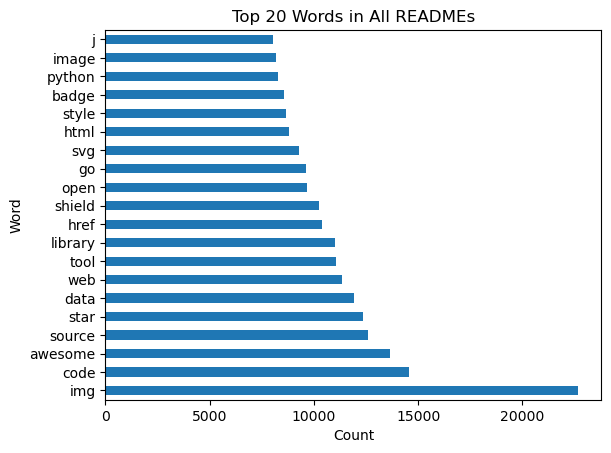

In [17]:
#visualize the top 20 words
word_counts['all'].sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in All READMEs')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

<div class="alert alert-success">    

### Insight: 
    
By cleaning the READMEs we were able to identify the top 20 actual words across all READMEs.
    <br>
* http has been removed as it was an outlier.
    
</div>

## 2. Does the length of the README vary by programming language?

$H_0$: The length of the readme does not vary by programming language


$H_a$: The programing language does vary by programming language

            letter_count
language                
go          32872.300000
html        20120.520000
java        26393.000000
javascript  22826.611111
other       22487.494157
python      23250.325000
shell       21935.894737


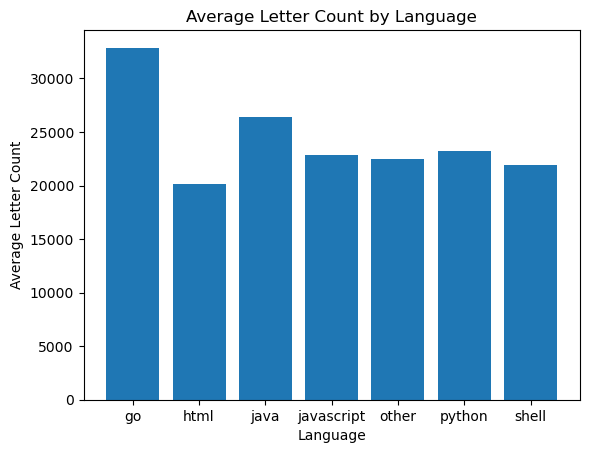

Levene Test Successful
p-value = nan. There is no significant difference between the means of language and letter_count.


In [18]:
#visualize the lengths of readmes against labels
ex.calculate_average_letter_count(df)

<div class="alert alert-success">    

### Insight: 
     
The average length of readmes by language varied but not significanly so, except for Go.
    <br>
</div>

## 3. Do different programming languages use a different number of unique words?

In [19]:
#look at the number of unique words per language
word_counts.drop(columns={'all', 'other'}).nunique().sort_values()

java          124
go            144
shell         179
html          185
javascript    255
python        269
dtype: int64

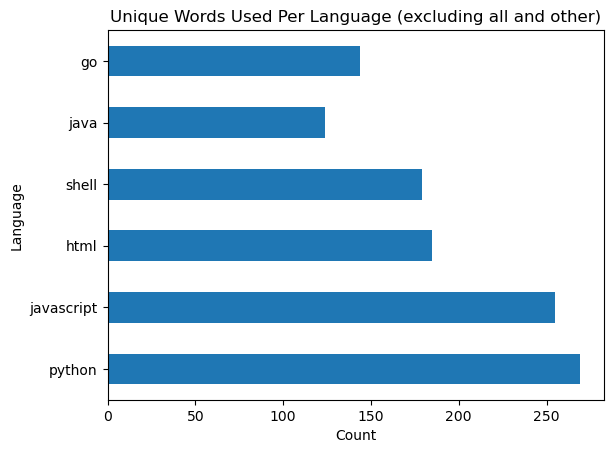

In [20]:
#visualize number of unique words per label
word_counts.drop(columns={'all', 'other'}).nunique().plot.barh()
plt.title('Unique Words Used Per Language (excluding all and other)')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()

<div class="alert alert-success">    

### Insight: 
    
When looking at the unique words per language we excluded the 'all' and 'other' columns and looked solely at explicitly defined languages.
    <br>
* As you can see, the number of unique words per language is slightly different.
* With Python being the highest at 269 and Java having the least amount with 124.
</div>

## 4. Are there any words that uniquely identify a programming language?

In [21]:
#look at the frequency of unique words per language
word_counts.sort_values('java', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1).round(2)

,all,python,javascript,html,shell,java,go,other
license,1.0,0.03,0.04,0.00,0.01,0.43,0.00,0.49
java,1.0,0.02,0.02,0.01,0.01,0.39,0.02,0.52
apache,1.0,0.03,0.02,0.01,0.07,0.34,0.00,0.53
business,1.0,0.02,0.03,0.00,0.01,0.61,0.00,0.32
friendly,1.0,0.01,0.02,0.01,0.01,0.70,0.01,0.25
star,1.0,0.10,0.20,0.00,0.00,0.10,0.00,0.60
img,1.0,0.12,0.07,0.00,0.01,0.05,0.01,0.74
useful,1.0,0.02,0.02,0.02,0.03,0.46,0.03,0.43
link,1.0,0.02,0.02,0.02,0.02,0.24,0.00,0.67
master,1.0,0.03,0.12,0.01,0.03,0.11,0.01,0.68


In [22]:
#another way to look at it using counts
word_counts.sort_values('java', ascending=False).head(20) # use a list to sort by more than one column!

,all,python,javascript,html,shell,java,go,other
license,6913,189,267,27,45,2951,31,3403
java,3743,81,84,45,47,1452,70,1964
apache,4158,125,76,39,275,1426,18,2199
business,2143,43,63,7,14,1312,10,694
friendly,1866,23,30,13,17,1302,15,466
star,12353,1211,2435,10,10,1242,7,7438
img,22653,2659,1573,112,268,1171,131,16739
useful,1833,33,30,39,52,846,49,784
link,3459,57,75,77,70,845,13,2322
master,7184,183,896,104,207,811,101,4882


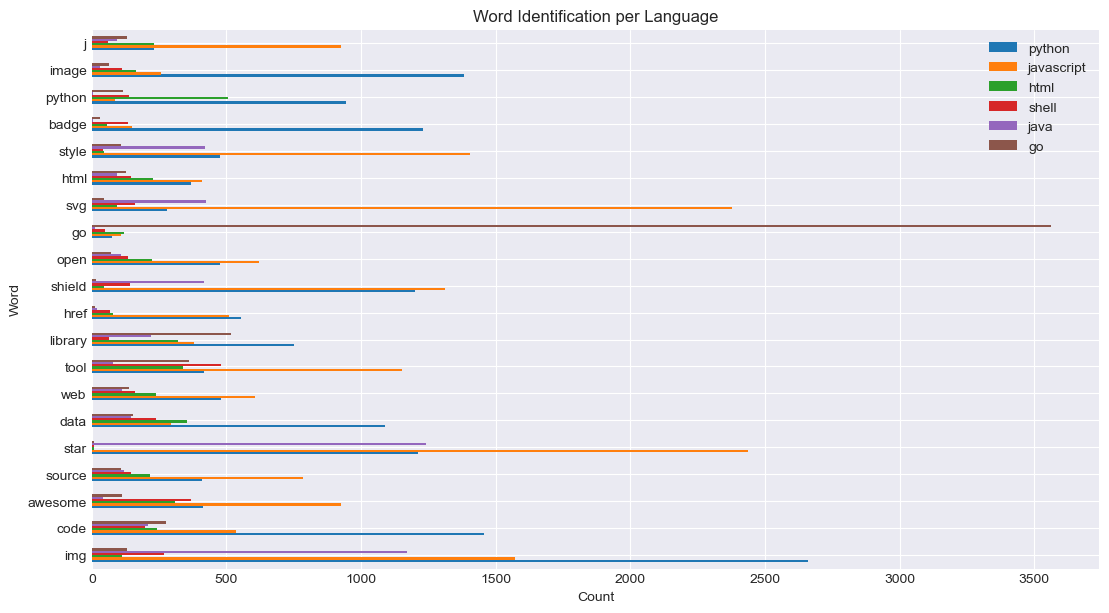

In [23]:
#visualizing the top 20 words sorted on all
ex.unique_words(word_counts)

<div class="alert alert-success">    

### Insight: 
    
The frequency of certain words does look like it can relate to specific languages. The above lists are sorted on the language 'java' and are only the top 20.
    <br>
* Python contains image, python, data, and code
* JavaScript contains j, style, svg, star, shield, and source
* HTML contains python, html, library, and data
* Shell contains awesome, tool, open, and code
* Java contains style, star, and shield
* Unsurprisingly, Go contains go 
    <br>
    
</div>

# `Preprocessing`

In [24]:
#make the count vectorizer thing to create the bag of words to prepare for modeling
bag_of_words = ev.make_bag_o_words(df, 'readme')

In [25]:
#splitting the data
train, validate, test = ev.split_data_strat(df, 'language')

Prepared DF: (740, 4)
Train: (444, 4)
Validate: (148, 4)
Test: (148, 4)


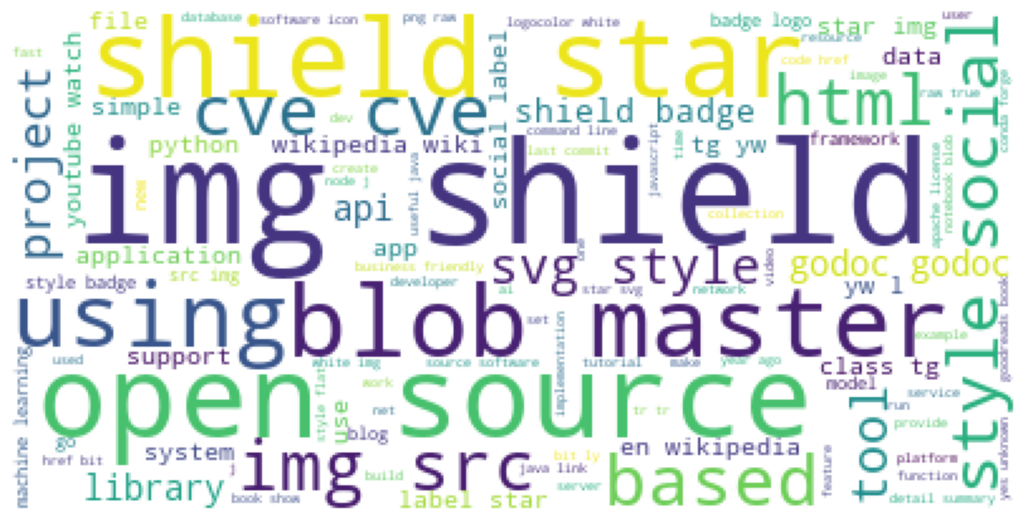

In [26]:
#train wordcloud
img = WordCloud(background_color='white').generate(' '.join(train.readme))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
#setting the baseline
train['baseline_prediction'] = 'other'

baseline_accuracy = (train.baseline_prediction == train.language).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 80.86%


In [28]:
#assign variables
X_train, y_train, X_validate, y_validate, X_test, y_test = ev.assign_variables(train, validate, test)

In [29]:
#make my bag of words
X_bow, X_validate_bow, X_test_bow = ev.make_variable_bag_o_words(X_train, X_validate, X_test)

# `Modeling`

In [30]:
ev.model_mbsmooth(X_bow, y_train, X_validate_bow, y_validate)

Multinomial Naive Bayes: `train` accuracy: 87.61%
Multinomial Naive Bayes: `validate` accuracy: 56.08%


> `this performed terribly likely because smoothing is occuring, since we filetered, we don't need smoothing.`

In [31]:
ev.model_mbnosmooth(X_bow, y_train, X_validate_bow, y_validate)

Multinomial Naive Bayes: `train` accuracy: 97.97%
Multinomial Naive Bayes: `validate` accuracy: 80.41%


> `MNB with alpha = 0 performed far better but still failed on validate_acc`

For depth of  1, the accuracy is 80.86%
For depth of  2, the accuracy is 80.86%
For depth of  3, the accuracy is 80.86%
For depth of  4, the accuracy is 80.86%
For depth of  5, the accuracy is 81.31%
For depth of  6, the accuracy is 81.76%
For depth of  7, the accuracy is 82.66%
For depth of  8, the accuracy is 82.66%
For depth of  9, the accuracy is 82.43%
For depth of 10, the accuracy is 83.78%
The baseline accuracy is 80.86%


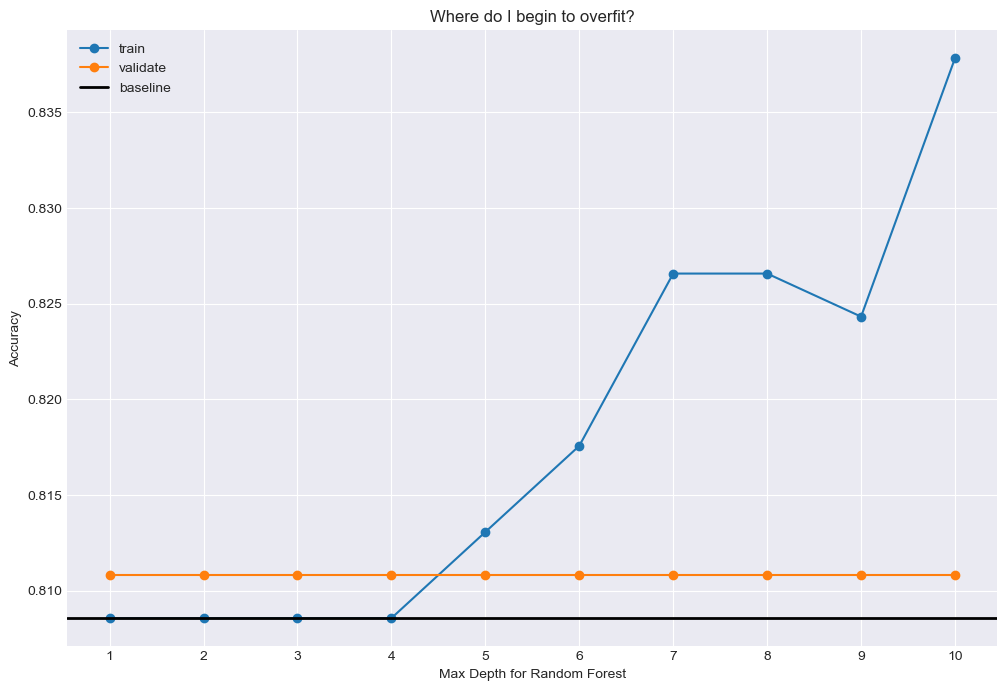

In [32]:
#random forest range of 10
ev.model_rf10(X_bow, y_train, X_validate_bow, y_validate, baseline_accuracy, x=10)

> `Random Forest with a depth of 4 performed well! Train and Validate both beat baseline: moving forward with this model`

In [33]:
ev.model_dt3(X_bow, y_train, X_validate_bow, y_validate)

Decision Tree / Max Depth = 3: `train` accuracy: 83.33%
Decision Tree / Max Depth = 3: `validate` accuracy: 80.41%


In [34]:
ev.model_knn5(X_bow, y_train, X_validate_bow, y_validate)

KNN / Neighbors = 5: `train` accuracy: 79.95%
KNN / Neighbors = 5: `validate` accuracy: 79.05%


In [35]:
ev.model_knn9(X_bow, y_train, X_validate_bow, y_validate)

KNN / Neighbors = 9: `train` accuracy: 81.08%
KNN / Neighbors = 9: `validate` accuracy: 81.08%


## TEST

In [36]:
ev.test_model(X_bow, y_train, X_test_bow, y_test, baseline_accuracy)

The baseline accuracy is 80.86%
The test accuracy is 81.08%


# `Conclusion`

<div class="alert alert-success">    
 
### Explore: 
    
---
    
We asked the following questions:
<br>
1. What are the most common words in READMEs?
2. Does the length of the README vary by programming language?
3. Do different programming languages use a different number of unique words?
4. Are there any words that uniquely identify a programming language?
<br>
    
The discoveries are as follows:
<br>
    
1. By cleaning the READMEs we were able to identify the top 20 actual words across all READMEs.
    * http has been removed as it was an outlier.
    * The rest of the top 20 words: img, code, awesome, source, star, data, web, tool, library, href, shield, open, go, svg, html, style, badge, python, image, j
<br>
    
2. The average length of readmes by language varied but not significanly.
    * Go seemed to have a spike though, but not significant.
<br>   
    
3. The number of unqiue words per langugage is only slightly different.
    * Python has the highest with 269
    * Java has the least with 124.

    <br>  
4. The frequency of certain words does look like it can relate to specific languages. 
    * Python contains image, python, data, and code
    * JavaScript contains j, style, svg, star, shield, and source
    * HTML contains python, html, library, and data
    * Shell contains awesome, tool, open, and code
    * Java contains style, star, and shield
    * Unsurprisingly, Go contains go 
    
<br>
    
---

### Modeling: 
    
---
    
Models Selected: 
    
**Baseline: 80.86%**
    
* Multinomial Naive Bayes with smoothing
    * Train: 87.61%
    * Valdiate: 56.08%
    
    <br>
    
* Multinomial Naive Bayes with no smoothing
    * Train: 97.97%
    * Validate: 80.41%
    
* Random Forest (tested depths 1-10, 4 performed best)
    * Train: 80.86%
    * Validate: 81.08%
    
    <br>
    
* Decision Tree
    * Depth of 3
        * Train: 83.33%
        * Validate: 80.41%

    <br>
    
* KNN 
    * Neighbors of 5
        * Train Accuracy: 79.95%
        * Validate Accuracy: 79.05%
    * Neighbors of 9
        * Train Accuracy: 81.08%
        * Validate Accuracy: 81.08%

* Test Model
    * Random Forest (depth of 4)
    * **Accuracy: 81.08%**
---   
</div>

# `Recommendations/Next Steps`

<div class="alert alert-success">   
    
We would create a column identifying the project type of each repo. Create a feature on github where individuals have to identify the subject that their project is looking into. This may involve user experience and interface engineers.
    
For the next iteration, I would like to use mostly unfiltered words just to see how it performs.
    
</div>    